# Predicting the Movie Genre from its Plot

## tl;dr

I built a NLP classifier that predicts a movie genre for a given plot. 

If you don't care about the model development, you can scroll down to the last cells, where I test my algorithm with 5 TV Shows and plot the results. 

## Introduction

For this project, I will be using a database from IMDB that consists of the genre and plot for around 4.5k movies. I will develop a model that is capable of predicting the movie genre for a given plot using machine learning algorithms (no word matching RegEx will be used).

In [76]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import wordnet as wn
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
from sklearn.base import clone

warnings.filterwarnings("ignore")

%matplotlib inline

In [25]:
def clean_sentence(sentence):
    sentence = sentence.lower()
    wordnet_lemmatizer = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    VERB_CODES = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', }
    
    new_sentence = []
    words = nltk.word_tokenize(sentence)
    role = nltk.pos_tag(words)
    for i, word in enumerate(words):
        if role[i][1] in VERB_CODES: 
            new_word = wordnet_lemmatizer.lemmatize(word, 'v')
        else:
            new_word = wordnet_lemmatizer.lemmatize(word)
        if new_word not in stop and new_word.isalpha():
            new_sentence.append(new_word)
        
    s = ' '.join(new_sentence)
    s = s.replace("n't", " not")
    s = s.replace("'s", " is")
    s = s.replace("'re"," are")
    s = s.replace("'d", " would")
    s = s.replace("'ve", " have")
    s = s.replace("'ll", " will")
    s = s.replace("'m", " am")
    return s

This dataset contains the plot and genre for about 4.5k movies on the IMDB website. I will be using it to develop a model capable of predicting a movie genre gor a given storyline.

In [13]:
data = pd.read_csv('https://raw.githubusercontent.com/ishmeetkohli/imdbGenreClassification/master/data/trainingSet.csv')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4456 entries, 0 to 4455
Data columns (total 6 columns):
imdbID    4456 non-null object
Title     4456 non-null object
Plot      4456 non-null object
Genre1    4456 non-null object
Genre2    3931 non-null object
Genre3    2673 non-null object
dtypes: object(6)
memory usage: 209.0+ KB


In [15]:
data.head()

,imdbID,Title,Plot,Genre1,Genre2,Genre3
0,tt0114709,Toy Story,A little boy named Andy loves to be in his roo...,Animation,Adventure,Comedy
1,tt0113497,Jumanji,After being trapped in a jungle board game for...,Action,Adventure,Family
2,tt0113228,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,Comedy,Romance,NaN
3,tt0114885,Waiting to Exhale,This story based on the best selling novel by ...,Comedy,Drama,Romance
4,tt0113041,Father of the Bride Part II,"In this sequel to ""Father of the Bride"", Georg...",Comedy,Family,Romance


It seems like Genre1 is the most obvious genre for a given movie, and Genre2 and 3 are some additional genres that a movie might have. This thought is confirme by the lack of null values in Genre1. Since Genre1 seems to cover the basic genre of each movie, I will focus on it.

In [16]:
data = data.drop(['imdbID', 'Genre2', 'Genre3'], axis='columns')

In [17]:
data.columns = ['title', 'plot', 'genre']

In [18]:
data.head()

,title,plot,genre
0,Toy Story,A little boy named Andy loves to be in his roo...,Animation
1,Jumanji,After being trapped in a jungle board game for...,Action
2,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,Comedy
3,Waiting to Exhale,This story based on the best selling novel by ...,Comedy
4,Father of the Bride Part II,"In this sequel to ""Father of the Bride"", Georg...",Comedy


Since we'll have to do some kind of vectorization on the sentences, it's better to make words that carry the same meaning be represented by the same symbol. So, we'll use the user-defined function 'clean_sentence' to lowercase it, clean all abbreviations and exclude stopwords. 

In [26]:
data['plot_clean'] = data['plot'].apply(clean_sentence)

In [27]:
data.head()

,title,plot,genre,plot_clean
0,Toy Story,A little boy named Andy loves to be in his roo...,Animation,little boy name andy love room play toy especi...
1,Jumanji,After being trapped in a jungle board game for...,Action,trap jungle board game year win release game s...
2,Grumpier Old Men,Things don't seem to change much in Wabasha Co...,Comedy,thing seem change much wabasha county max john...
3,Waiting to Exhale,This story based on the best selling novel by ...,Comedy,story base best selling novel terry mcmillan f...
4,Father of the Bride Part II,"In this sequel to ""Father of the Bride"", Georg...",Comedy,sequel father bride george bank must accept re...


In [101]:
print('Absolute Values')
data.genre.value_counts()

Absolute Values


Comedy         1339
Drama           876
Action          765
Crime           328
Animation       245
Documentary     238
Adventure       223
Biography       204
Horror          127
Fantasy          28
Mystery          22
Romance          17
Sci-Fi           13
Family           11
Thriller          9
Short             7
War               2
Western           1
Musical           1
Name: genre, dtype: int64

In [29]:
print('Percentage of Data Points')
round(100*data.genre.value_counts()/len(data),2)

Percentage of Data Points


Comedy         30.05
Drama          19.66
Action         17.17
Crime           7.36
Animation       5.50
Documentary     5.34
Adventure       5.00
Biography       4.58
Horror          2.85
Fantasy         0.63
Mystery         0.49
Romance         0.38
Sci-Fi          0.29
Family          0.25
Thriller        0.20
Short           0.16
War             0.04
Western         0.02
Musical         0.02
Name: genre, dtype: float64

There's a clear unbalance of classes on this dataset. Genres such as Western and Musical appear only once on it while Comedy makes up 30% of the whole dataset. This issue has to be addressed when modeling the problem.

In [30]:
genres = data.genre.value_counts().reset_index()['index']

In [31]:
genres

0          Comedy
1           Drama
2          Action
3           Crime
4       Animation
5     Documentary
6       Adventure
7       Biography
8          Horror
9         Fantasy
10        Mystery
11        Romance
12         Sci-Fi
13         Family
14       Thriller
15          Short
16            War
17        Western
18        Musical
Name: index, dtype: object

# Traditional Approach

I will first start with the traditional approach, which means that I will vectorize each text using a Bag of Words model (Count or TfIdf Vectorizers) and then use a common classifier, such as Logistic Regression.

In [89]:
vectorizer = {'tfidf':TfidfVectorizer(), 
              'count':CountVectorizer()}

classifier = {'sgdc':SGDClassifier(), 
              'multinomial_nb': MultinomialNB(),
              'random_forest': RandomForestClassifier(),
              'logistic_regression': LogisticRegression()}

I will be using only the 9 most abundant genres, because after that, the dataset doesn't have enough data points to make predictions.

In [332]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iterations = n_vec*n_clf

for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['genre']]
    k = 1
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
            print(genre.upper() + ' [' + str(k) + '/' +str(n_iterations) + ']: ' + vect_name + ' - ' + clf_name )
            kf = KFold(n_splits=5, random_state=None, shuffle=False)
            pipe = Pipeline([('vect', vect), ('clf', clf)])
            
            acc = []
            prec = []
            rec = []
            f1 = []
            for train_index, test_index in kf.split(data):
                x_train, y_train = data.plot_clean.iloc[train_index], data.genre_y.iloc[train_index]
                x_test, y_test = data.plot_clean.iloc[test_index], data.genre_y.iloc[test_index]
                pipe.fit(x_train, y_train)
                y_pred = pipe.predict(x_test)
                acc.append(np.mean(y_pred==y_test))
                prec.append(precision_score(y_test, y_pred))
                rec.append(recall_score(y_test, y_pred))
                f1.append(f1_score(y_test, y_pred))
            print('Summary: ' + 
                  'accuracy = ' + str(round(np.mean(acc),2)) + ' | ' + 
                  'precision = ' + str(round(np.mean(prec),2)) + ' | ' +
                  'recall = ' + str(round(np.mean(rec),2)) + ' | ' +
                  'f1 = ' + str(round(np.mean(f1),2)))
            print()
            k+=1
        print('------')


COMEDY [1/8]: tfidf - sgdc
Summary: accuracy = 0.74 | precision = 0.59 | recall = 0.45 | f1 = 0.51

COMEDY [2/8]: tfidf - multinomial_nb
Summary: accuracy = 0.7 | precision = 0.0 | recall = 0.0 | f1 = 0.0

COMEDY [3/8]: tfidf - random_forest
Summary: accuracy = 0.71 | precision = 0.58 | recall = 0.15 | f1 = 0.23

COMEDY [4/8]: tfidf - logistic_regression
Summary: accuracy = 0.74 | precision = 0.74 | recall = 0.2 | f1 = 0.32

------
COMEDY [5/8]: count - sgdc
Summary: accuracy = 0.72 | precision = 0.54 | recall = 0.51 | f1 = 0.52

COMEDY [6/8]: count - multinomial_nb
Summary: accuracy = 0.77 | precision = 0.65 | recall = 0.51 | f1 = 0.57

COMEDY [7/8]: count - random_forest
Summary: accuracy = 0.71 | precision = 0.58 | recall = 0.17 | f1 = 0.26

COMEDY [8/8]: count - logistic_regression
Summary: accuracy = 0.75 | precision = 0.6 | recall = 0.47 | f1 = 0.53

------
DRAMA [1/8]: tfidf - sgdc
Summary: accuracy = 0.79 | precision = 0.43 | recall = 0.24 | f1 = 0.31

DRAMA [2/8]: tfidf - mult

The high accuracy and low precision numbers hint at an imbalance problem. That means that the classifier is most likely only guessing the most common category to all predictions, therefore resulting in a high accuracy algorithm.
In order to fix it, I'll use two common solutions: Oversampling and Undersampling.

Oversampling basically means that we'll generate more data for the least common category using the SMOTE algorithm. Undersampling means that we'll remove data from the most common category using the Edited Nearest Neighbors algorithm.

Finally, for each genre, I'll find what's the combination of vectorizes, classifier and sampling method that gives us the best AUC score. Later on, I'll use this information to train the final classifier for real predictions.

In [99]:
n_vec = len(vectorizer)
n_clf = len(classifier)

n_iterations = n_vec*n_clf

temp = data.copy()

test_result = {}

for genre in genres[:9]:
    temp['genre_y'] = [1 if y == genre else 0 for y in temp['genre']]
    k = 1
    final_score = {}
    for vect_name, vect in vectorizer.items():
        for clf_name, clf in classifier.items():
            print('>> ' + genre.upper() + ' [' + str(k) + '/' +str(n_iterations) + ']: ' + vect_name + ' - ' + clf_name )
            kf = KFold(n_splits=3, random_state=None, shuffle=False)
            
            acc_normal = []
            prec_normal = []
            rec_normal = []
            f1_normal = []
            auc_normal = []
            
            acc_over = []
            prec_over = []
            rec_over = []
            f1_over = []
            auc_over = []
            
            acc_under = []
            prec_under = []
            rec_under = []
            f1_under = []
            auc_under = []
            
            i = 1
            x, y = temp.plot_clean, temp.genre_y
            for train_index, test_index in kf.split(data):
                x_train, y_train = x.iloc[train_index], y.iloc[train_index]
                x_test, y_test = x.iloc[test_index], y.iloc[test_index]
                
                train_vect = vect.fit_transform(x_train)
                
                clf.fit(train_vect, y_train)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_normal.append(np.mean(y_pred==y_test))
                prec_normal.append(precision_score(y_test, y_pred))
                rec_normal.append(recall_score(y_test, y_pred))
                f1_normal.append(f1_score(y_test, y_pred))
                auc_normal.append(roc_auc_score(y_test, y_pred))
#                 print('NORMAL: iteration ' + str(i) + ': ' + str(get_raw_from_cm(confusion_matrix(y_test, y_pred))))
                
                train_vect_over, y_train_over = SMOTE().fit_sample(train_vect, y_train) 
                clf.fit(train_vect_over, y_train_over)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_over.append(np.mean(y_pred==y_test))
                prec_over.append(precision_score(y_test, y_pred))
                rec_over.append(recall_score(y_test, y_pred))
                f1_over.append(f1_score(y_test, y_pred))
                auc_over.append(roc_auc_score(y_test, y_pred))
#                 print('Overfitting: iteration ' + str(i) + ': ' + str(get_raw_from_cm(confusion_matrix(y_test, y_pred))))
                
                train_vect_under, y_train_under = EditedNearestNeighbours().fit_sample(train_vect, y_train) 
                clf.fit(train_vect_under, y_train_under)
                
                test_vect = vect.transform(x_test)
                y_pred = clf.predict(test_vect)

                acc_under.append(np.mean(y_pred==y_test))
                prec_under.append(precision_score(y_test, y_pred))
                rec_under.append(recall_score(y_test, y_pred))
                f1_under.append(f1_score(y_test, y_pred))
                auc_under.append(roc_auc_score(y_test, y_pred))
#                 print('Underfitting: iteration ' + str(i) + ': ' + str(get_raw_from_cm(confusion_matrix(y_test, y_pred))))
#                 print()
                
                
                i+=1
                
            print('Summary Normal: ' + 
                  'accuracy = ' + str(round(np.mean(acc_normal),2)) + ' | ' + 
                  'precision = ' + str(round(np.mean(prec_normal),2)) + ' | ' +
                  'recall = ' + str(round(np.mean(rec_normal),2)) + ' | ' +
                  'f1 = ' + str(round(np.mean(f1_normal),2)) + ' | ' + 
                  'auc = ' + str(round(np.mean(auc_normal),2))
                 )
            
            print('Summary Over Sampling: ' + 
                  'accuracy = ' + str(round(np.mean(acc_over),2)) + ' | ' + 
                  'precision = ' + str(round(np.mean(prec_over),2)) + ' | ' +
                  'recall = ' + str(round(np.mean(rec_over),2)) + ' | ' +
                  'f1 = ' + str(round(np.mean(f1_over),2)) + ' | ' + 
                  'auc = ' + str(round(np.mean(auc_over),2))
                 )
            
            print('Summary Under Sampling: ' + 
                  'accuracy = ' + str(round(np.mean(acc_under),2)) + ' | ' + 
                  'precision = ' + str(round(np.mean(prec_under),2)) + ' | ' +
                  'recall = ' + str(round(np.mean(rec_under),2)) + ' | ' +
                  'f1 = ' + str(round(np.mean(f1_under),2)) + ' | ' + 
                  'auc = ' + str(round(np.mean(auc_under),2))
                 )
            print()
            k+=1
            final_score[(vect_name, clf_name, 'over')] = np.mean(auc_over)
            final_score[(vect_name, clf_name, 'normal')] = np.mean(auc_normal)
            final_score[(vect_name, clf_name, 'under')] = np.mean(auc_under)
        print('------')
    test_result[genre] = max(final_score, key=final_score.get)


>> COMEDY [1/8]: tfidf - sgdc
Summary Normal: accuracy = 0.95 | precision = 0.65 | recall = 0.13 | f1 = 0.21 | auc = 0.56
Summary Over Sampling: accuracy = 0.95 | precision = 0.57 | recall = 0.14 | f1 = 0.21 | auc = 0.57
Summary Under Sampling: accuracy = 0.95 | precision = 0.53 | recall = 0.18 | f1 = 0.25 | auc = 0.59

>> COMEDY [2/8]: tfidf - multinomial_nb
Summary Normal: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.91 | precision = 0.31 | recall = 0.52 | f1 = 0.37 | auc = 0.73
Summary Under Sampling: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5

>> COMEDY [3/8]: tfidf - random_forest
Summary Normal: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.94 | precision = 0.39 | recall = 0.02 | f1 = 0.04 | auc = 0.51
Summary Under Sampling: accuracy = 0.95 | precision = 0.27 | recall = 0.02 | f1 = 0.04 | auc = 0.51

>> COMEDY [4/8]: tfidf - lo

Summary Normal: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.91 | precision = 0.31 | recall = 0.5 | f1 = 0.36 | auc = 0.72
Summary Under Sampling: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5

>> CRIME [3/8]: tfidf - random_forest
Summary Normal: accuracy = 0.95 | precision = 0.33 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.94 | precision = 0.28 | recall = 0.01 | f1 = 0.02 | auc = 0.5
Summary Under Sampling: accuracy = 0.94 | precision = 0.31 | recall = 0.02 | f1 = 0.04 | auc = 0.51

>> CRIME [4/8]: tfidf - logistic_regression
Summary Normal: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.94 | precision = 0.43 | recall = 0.24 | f1 = 0.3 | auc = 0.61
Summary Under Sampling: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5

------
>> CRIME [5/8]: count - sgdc
Summary Normal: accuracy = 0

Summary Normal: accuracy = 0.95 | precision = 0.33 | recall = 0.01 | f1 = 0.02 | auc = 0.51
Summary Over Sampling: accuracy = 0.94 | precision = 0.13 | recall = 0.02 | f1 = 0.04 | auc = 0.51
Summary Under Sampling: accuracy = 0.95 | precision = 0.33 | recall = 0.01 | f1 = 0.01 | auc = 0.5

>> ADVENTURE [4/8]: tfidf - logistic_regression
Summary Normal: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5
Summary Over Sampling: accuracy = 0.94 | precision = 0.43 | recall = 0.23 | f1 = 0.29 | auc = 0.61
Summary Under Sampling: accuracy = 0.95 | precision = 0.0 | recall = 0.0 | f1 = 0.0 | auc = 0.5

------
>> ADVENTURE [5/8]: count - sgdc
Summary Normal: accuracy = 0.93 | precision = 0.28 | recall = 0.15 | f1 = 0.17 | auc = 0.56
Summary Over Sampling: accuracy = 0.94 | precision = 0.38 | recall = 0.18 | f1 = 0.22 | auc = 0.58
Summary Under Sampling: accuracy = 0.91 | precision = 0.28 | recall = 0.24 | f1 = 0.22 | auc = 0.6

>> ADVENTURE [6/8]: count - multinomial_nb
Sum

In [329]:
test_result

{'Action': ('tfidf', 'multinomial_nb', 'over'),
 'Adventure': ('tfidf', 'multinomial_nb', 'over'),
 'Animation': ('tfidf', 'multinomial_nb', 'over'),
 'Biography': ('tfidf', 'multinomial_nb', 'over'),
 'Comedy': ('tfidf', 'multinomial_nb', 'over'),
 'Crime': ('tfidf', 'multinomial_nb', 'over'),
 'Documentary': ('tfidf', 'multinomial_nb', 'over'),
 'Drama': ('tfidf', 'multinomial_nb', 'over'),
 'Horror': ('tfidf', 'multinomial_nb', 'over')}

Apparently, TFIDF + Multinomial Naive Bayes + Oversampling yields the best AUC score for all 9 genres. 

I will use the information contained on the test_result dictionary to train each genre classifier accordingly. Each genre will have its own classifier, that is, instead of having a multilabel classifier that is able to tell if a plot contains elements of a Horror movie or a Comedy, I'll build 9 different classifier that will, each one, tell if that plot contains elements of that genre or not.

In [328]:
pipe_dict = {}
for genre in genres[:9]:
    data['genre_y'] = [1 if y == genre else 0 for y in data['genre']]
    vect_name = test_result[genre][0]
    clf_name = test_result[genre][1]
    sampling_name = test_result[genre][2]

    vect = clone(vectorizer[vect_name])
    clf = clone(classifier[clf_name])
    
    x_vect = vect.fit_transform(data.plot_clean)
    
    if sampling_name == 'normal':
        clf.fit(x_vect, data.genre_y)
    elif sampling_name == 'over':
        x_vect, y = SMOTE().fit_sample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    elif sampling_name == 'under':
        x_vect, y = EditedNearestNeighbours().fit_sample(x_vect, data.genre_y)
        clf.fit(x_vect, y)
    pipe_dict[genre] = Pipeline([('vect', vect), ('clf', clf)])

This function outputs a horizontal bar graph that shows, for each genre, what's the probability of that plot belonging to that genre.

In [342]:
def predict_genre(s, pipe_dict):
    s_new = clean_sentence(s)
    genre_analyzed = []
    proba = []
    for genre, pipe in pipe_dict.items():
        res = pipe.predict_proba([s_new])
        genre_analyzed.append(genre)
        proba.append(res[0][1])
    data = pd.DataFrame({'genre': genre_analyzed, 'proba': proba})
    data = data.sort_values(by='proba', ascending=True)
    ax = data.plot(x='genre', y='proba', kind='barh')
    plt.show()

For a quick evaluation of the model, I will test it with TV Shows that were not contained in the dataset.

## 1. Sherlock (BBC Series)

In [343]:
movie_plot = """ 

In this modernized version of the Conan Doyle characters, using his detective plots, Sherlock Holmes lives in early 21st century London and acts more cocky towards Scotland Yard's detective inspector Lestrade because he's actually less confident. Doctor Watson is now a fairly young veteran of the Afghan war, less adoring and more active.

"""

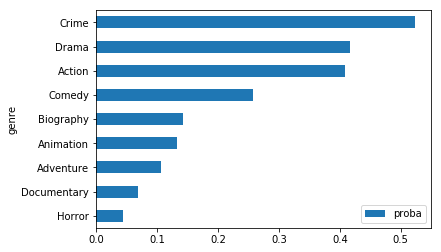

In [344]:
predict_genre(movie_plot, pipe_dict)

## 2. Rick and Morty

In [359]:
movie_plot = """ 

An animated series on adult-swim about the infinite adventures of Rick, a genius alcoholic and careless scientist, with his grandson Morty, a 14 year-old anxious boy who is not so smart. Together, they explore the infinite universes; causing mayhem and running into trouble.

"""

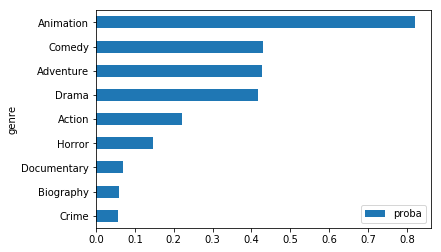

In [360]:
predict_genre(movie_plot, pipe_dict)

## 3. The Office (American Version)

In [361]:
movie_plot = """ 

The everyday lives of workers at a paper company are caught on camera by a camera crew for a documentary. Some of these workers are Micheal Scott, the boss who isn't too bright or funny. Dwight Shrute, a salesman who takes his job very, very, seriously. Jim Halpert, a salesman who is the office cool guy and prankster. And Pam Beesly, the receptionist who is engaged but who is also the crush of someone else in the office. With these characters, the daily anticts of this branch is anything but normal.

"""

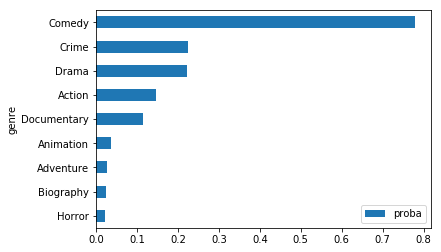

In [362]:
predict_genre(movie_plot, pipe_dict)

## 4. Game of Thrones

In [353]:
movie_plot = """ 

In the mythical continent of Westeros, several powerful families fight for control of the Seven Kingdoms. As conflict erupts in the kingdoms of men, an ancient enemy rises once again to threaten them all. Meanwhile, the last heirs of a recently usurped dynasty plot to take back their homeland from across the Narrow Sea.

"""

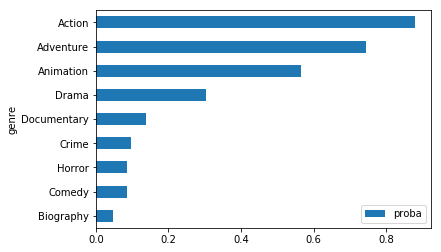

In [354]:
predict_genre(movie_plot, pipe_dict)

## 5. The Wire

In [355]:
movie_plot = """ 

Set in Baltimore, this show centers around the city's inner-city drug scene. It starts as mid-level drug dealer, D'Angelo Barksdale beats a murder rap. After a conversation with a judge, Det. James McNulty has been assigned to lead a joint homicide and narcotics team, in order to bring down drug kingpin Avon Barksdale. Avon Barksdale, accompanied by his right-hand man Stringer Bell, enforcer Wee-Bey and many lieutenants (including his own nephew, D'Angelo Barksdale), has to deal with law enforcement, informants in his own camp, and competition with a local rival, Omar, who's been robbing Barksdale's dealers and reselling the drugs. The supervisor of the investigation, Lt. Cedric Daniels, has to deal with his own problems, such as a corrupt bureaucracy, some of his detectives beating suspects, hard-headed but determined Det. McNulty, and a blackmailing deputy. The show depicts the lives of every part of the drug "food chain", from junkies to dealers, and from cops to politicians.

"""

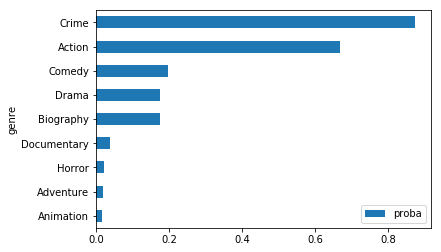

In [356]:
predict_genre(movie_plot, pipe_dict)

The classifier seems to be performing pretty well, although some improvements are certainly possible.
Possible improvements:

1) Use the name of actors (Adam Sandler is probably going to star in comedies, for example

2) Use Neural Networks (usually some word embedding algorithm and a CNN)

3) Use a GridSearch to find the best parameters for the classifier and the vectorizer (such as min_df/ max_df)